In [25]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from geopy.geocoders import Nominatim
import time
import contextily as ctx

brasil = gpd.read_file('BR_UF_2024/BR_UF_2024.shp')

dados = pd.DataFrame({
    'Cidade': [
        'Lucas do\nRio Verde',
        'Sinop',
        'Balsas',
        'Maracaju',
        'Quirinópolis',
        'Luís Eduardo\nMagalhães',
        'Cristalina',
        'Campo Mourão',
        'Canarana',
    ],
    'Estado': ['MT', 'MT', 'MA', 'MS', 'GO', 'BA', 'GO', 'PR', 'MT'],
    'Valor (R$ mi)': [25, 23, 10, 3, 2, 5, 2, 3, 2],
    'Cor': ['v', 'v', 'a', 'v', 'v', 'a', 'a', 'v', 'a']
})

geolocator = Nominatim(user_agent="geo_app")

# Função para pegar coordenadas
def get_coords(cidade, estado):
    try:
        location = geolocator.geocode(f"{cidade}, {estado}, Brasil")
        if location:
            return location.latitude, location.longitude
        else:
            return None, None
    except:
        return None, None

# ======================
# 3. Adicionar latitude e longitude no DataFrame
# ======================
latitudes = []
longitudes = []

for i, row in dados.iterrows():
    lat, lon = get_coords(row['Cidade'], row['Estado'])
    latitudes.append(lat)
    longitudes.append(lon)
    time.sleep(1)  # pausa para não sobrecarregar o servidor do OpenStreetMap

dados['Latitude'] = latitudes
dados['Longitude'] = longitudes

print(dados.head())

                Cidade Estado  Valor (R$ mi) Cor   Latitude  Longitude
0  Lucas do\nRio Verde     MT             25   v -13.066461 -55.919671
1                Sinop     MT             23   v -11.857701 -55.496782
2               Balsas     MA             10   a  -7.532140 -46.037163
3             Maracaju     MS              3   v -21.616301 -55.164605
4         Quirinópolis     GO              2   v -18.447186 -50.454698


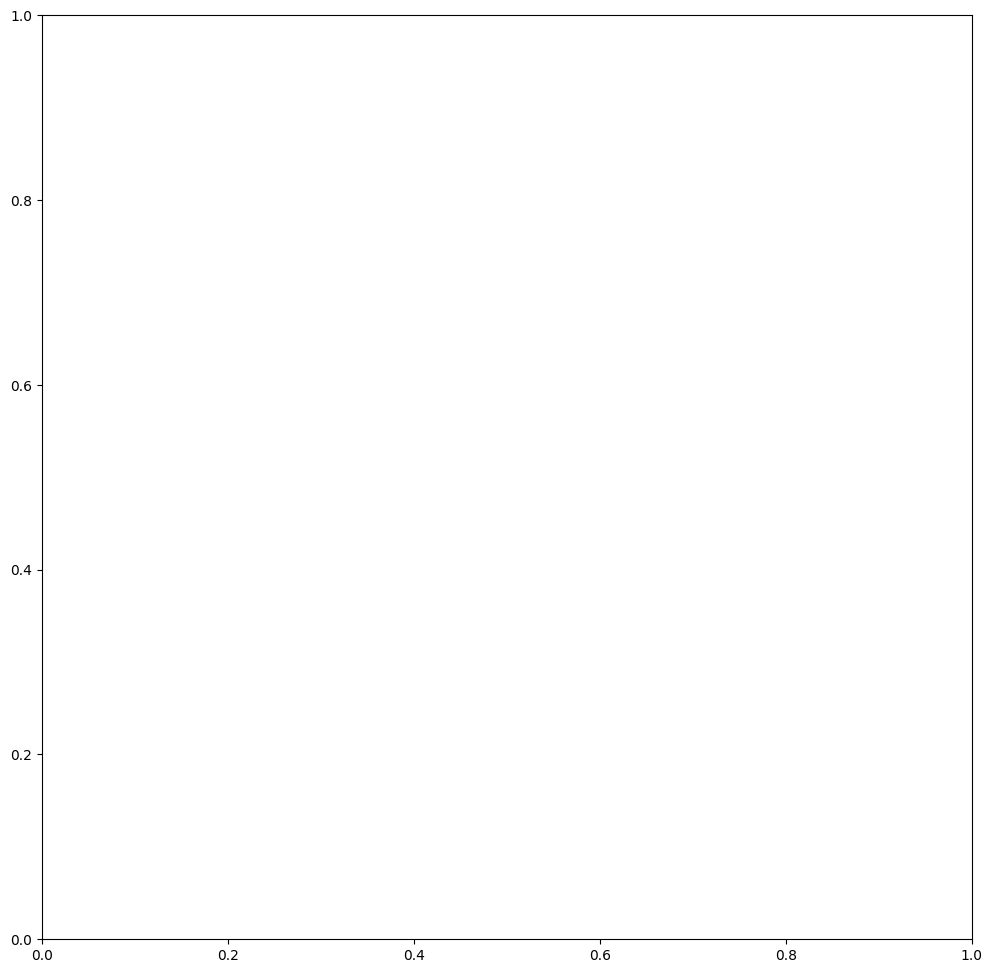

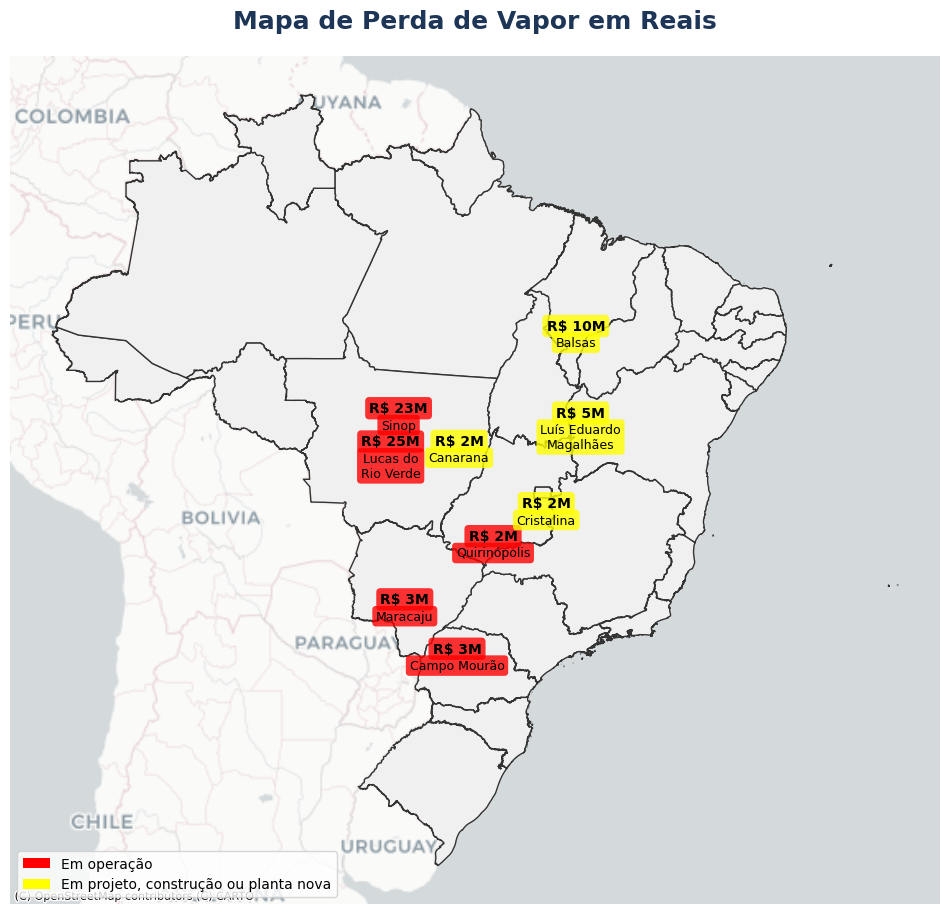

In [26]:
df = pd.DataFrame(dados)

# Criar GeoDataFrame
gdf = gpd.GeoDataFrame(
    df,
    geometry=[Point(xy) for xy in zip(df["Longitude"], df["Latitude"])],
    crs="EPSG:4326"
)
gdf = gdf.to_crs(epsg=3857)

# ======================
# 2. Mapa do Brasil (shapefile ou naturalearth_lowres)
# ======================
brasil = gpd.read_file("BR_UF_2024/BR_UF_2024.shp")
brasil = brasil.to_crs(epsg=3857)  # converter para Web Mercator
# ======================
# 3. Plot
# ======================
fig, ax = plt.subplots(figsize=(12, 12))

# ======================
# Plot com caixas grifadas em vermelho/amarelo e texto preto
# ======================
fig, ax = plt.subplots(figsize=(12, 12))

# Mapa do Brasil
brasil.plot(ax=ax, color="#f0f0f0", edgecolor="#333333")

# Dicionário de deslocamento para rótulos
deslocamentos = {
    "Lucas do\nRio Verde": (0, -60000),
    "Sinop": (0, 0),
    "Balsas": (0, 0),
    "Maracaju": (0, 0),
    "Quirinópolis": (0, 0),
    "Luís Eduardo Magalhães": (0, 0),
    "Cristalina": (0, 0),
    "Campo Mourão": (0, 0),
    "Canarana": (0, 0),
    "Goiás": (0, 0)
}

# Mapear letras para cores de fundo
cor_fundo = {"v": "red", "a": "yellow"}

# Plotar cada cidade
for x, y, valor, nome, cor_letra in zip(
        gdf.geometry.x, gdf.geometry.y, gdf["Valor (R$ mi)"], gdf["Cidade"], gdf["Cor"]):
    
    dx, dy = deslocamentos.get(nome, (0, 0))
    fundo = cor_fundo.get(cor_letra, "gray")
    texto = "black"
    
    # Se valor for 0, mostrar "Nova Planta"
    valor_texto = f"R$ {valor}M" if valor != 0 else "Nova"
    
    # Caixa para o valor
    ax.text(
        x + dx,
        y + dy + 10000,
        valor_texto,
        fontsize=10,
        ha="center",
        va="bottom",
        fontweight="bold",
        color=texto,
        bbox=dict(
            facecolor=fundo,
            alpha=0.8,
            edgecolor="none",
            boxstyle="round,pad=0.3"
        )
    )
    
    # Caixa para o nome da cidade
    ax.text(
        x + dx,
        y + dy - 10000,
        nome,
        fontsize=9,
        ha="center",
        va="top",
        color=texto,
        bbox=dict(
            facecolor=fundo,
            alpha=0.8,
            edgecolor="none",
            boxstyle="round,pad=0.3"
        )
    )

# Criar legendas manualmente
import matplotlib.patches as mpatches
vermelho = mpatches.Patch(facecolor='red', edgecolor='none', label='Em operação')
amarelo = mpatches.Patch(facecolor='yellow', edgecolor='none', label='Em projeto, construção ou planta nova')
ax.legend(handles=[vermelho, amarelo], loc='lower left', fontsize=10, frameon=True)

# Limpar visual e adicionar basemap
ax.set_axis_off()
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zoom=4)

plt.title("Mapa de Perda de Vapor em Reais", fontsize=18, fontweight="bold", color="#1d3557", pad=20)
plt.show()